In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Working on {device}")

Working on cpu


## Target Function

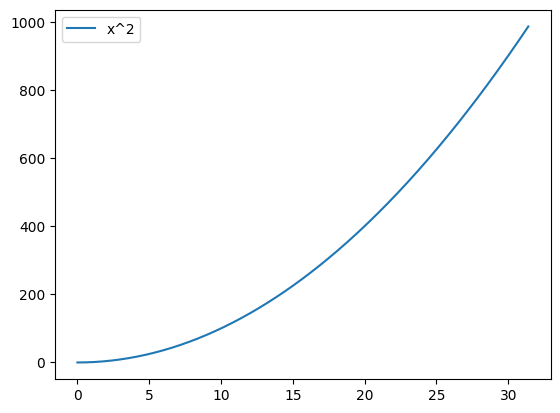

In [3]:
def targetFunc(x):
    """
    Target Funtion for curve fitting
    """
    return x * x

x = np.arange(0, 10 * np.pi, 0.1)
plt.plot(x, [targetFunc(i) for i in x])
plt.legend(["x^2"])

## Dataset & Dataloader

In [ ]:
x = np.arange(0, 5 * np.pi, 0.001)
y = [targetFunc(i) for i in x]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1)

print(f"Training dataset:{X_train.shape}")
print(f"Validation dataset:{X_val.shape}")
print(f"Test dataset:{X_test.shape}")

Training dataset:(10995,)
Validation dataset:(1571,)
Test dataset:(3142,)


In [ ]:
class CurveDataset(Dataset):
    """
    Curve Dataset
    """
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

In [ ]:
train_dataset = CurveDataset(X_train, y_train)
val_dataset = CurveDataset(X_val, y_val)
test_dataset = CurveDataset(X_test, y_test)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
next(iter(train_dataloader))

[tensor([14.0880,  2.8380,  2.1030,  3.1460, 13.0270,  0.0480,  8.2080, 14.1980,
          4.3270,  8.3590,  3.0120,  6.7320, 13.7220,  8.9140,  8.9120,  7.2050,
          6.1660,  7.9400,  3.4540, 14.5580, 11.2280,  7.9780, 12.6550, 15.5130,
         11.0530,  7.6960,  6.2710,  9.1420,  6.6380, 12.6590, 12.3050,  3.5750],
        dtype=torch.float64),
 tensor([1.9847e+02, 8.0542e+00, 4.4226e+00, 9.8973e+00, 1.6970e+02, 2.3040e-03,
         6.7371e+01, 2.0158e+02, 1.8723e+01, 6.9873e+01, 9.0721e+00, 4.5320e+01,
         1.8829e+02, 7.9459e+01, 7.9424e+01, 5.1912e+01, 3.8020e+01, 6.3044e+01,
         1.1930e+01, 2.1194e+02, 1.2607e+02, 6.3648e+01, 1.6015e+02, 2.4065e+02,
         1.2217e+02, 5.9228e+01, 3.9325e+01, 8.3576e+01, 4.4063e+01, 1.6025e+02,
         1.5141e+02, 1.2781e+01], dtype=torch.float64)]

## Model

In [ ]:
class MLP(nn.Module):
    """
    2 layer perceptron with ReLU activation
    """
    def __init__(self, in_features=1, out_features=1):
        super().__init__()
        self.FC1 = nn.Linear(in_features=in_features,
                             out_features=10)
        self.relu = nn.ReLU()
        self.FC2 = nn.Linear(in_features=10,
                             out_features=out_features)

    def forward(self, x):
        x = self.FC1(x)
        x = self.relu(x)
        outputs = self.FC2(x)
        return outputs

In [ ]:
model = MLP()
model

MLP(
  (FC1): Linear(in_features=1, out_features=10, bias=True)
  (relu): ReLU()
  (FC2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
def weights_init(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
model.apply(weights_init)

MLP(
  (FC1): Linear(in_features=1, out_features=10, bias=True)
  (relu): ReLU()
  (FC2): Linear(in_features=10, out_features=1, bias=True)
)

## Optimizer & Loss function

In [ ]:
loss_fn = nn.L1Loss()

In [ ]:

def val(model, dataloader, loss_fn, device='cpu'):
    """
    Validation Function
    """
    model.to(device)
    model.eval()
    with torch.inference_mode():
        rec_loss = 0
        for X, y in dataloader:
            X = X.to(device).unsqueeze(-1).float()
            y = y.to(device).unsqueeze(-1).float()
            logits = model(X)
            loss = loss_fn(logits, y)
            rec_loss += loss
        print(f"Validation loss:{rec_loss / len(dataloader)}")


def training(model, dataloader, val_dataloader, loss_fn, lr=0.001, epochs=50, device='cpu', verbose_epoch=10):
    """
    Training function
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):
        model.train()
        rec_loss = 0
        for X, y in dataloader:
            X = X.to(device).unsqueeze(-1).float()
            y = y.to(device).unsqueeze(-1).float()

            logits = model(X)
            loss = loss_fn(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            rec_loss += loss

        if epoch % verbose_epoch == 0:
            print(f"Epoch{epoch}\tLoss{rec_loss / len(dataloader)}")
            val(model, val_dataloader, loss_fn, device)


## Training & Evaluation

In [ ]:
def test(model, ranger, steper, loss_fn, device='cpu'):
    """
    Test Function
    """
    model.to(device)
    model.eval()
    x = []
    y_pred = []
    with torch.inference_mode():
        rec_loss = 0
        for X in range(ranger[0], ranger[1], steper):
            X = torch.tensor(X).to(device).unsqueeze(-1).float()
            y = torch.tensor([targetFunc(i) for i in X]).to(device).unsqueeze(-1).float()

            logits = model(X)
            loss = loss_fn(logits, y)
            rec_loss += loss

            x.extend(X.unsqueeze(1))
            y_pred.extend(logits.unsqueeze(1))
        print(f"Test loss:{rec_loss * steper / (ranger[1] - ranger[0])}")

    x = [i.cpu().numpy() for i in x]
    y_pred = [i.cpu().numpy() for i in y_pred]

    plt.plot(x, [targetFunc(i) for i in x])
    plt.plot(x, y_pred)
    plt.legend(["Ground truth", "Prediction"])

In [ ]:
training(model, train_dataloader, val_dataloader, loss_fn, lr=0.001, epochs=100, device=device, verbose_epoch=10)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch0	Loss0.5147085785865784


  1%|          | 1/100 [00:01<02:09,  1.30s/it]

Validation loss:0.5246576070785522


 10%|█         | 10/100 [00:06<01:03,  1.43it/s]

Epoch10	Loss0.5140900015830994


 11%|█         | 11/100 [00:07<01:09,  1.27it/s]

Validation loss:0.5454655289649963


 20%|██        | 20/100 [00:12<00:41,  1.91it/s]

Epoch20	Loss0.5119367837905884


 21%|██        | 21/100 [00:13<00:47,  1.66it/s]

Validation loss:0.5316381454467773


 30%|███       | 30/100 [00:18<00:35,  1.98it/s]

Epoch30	Loss0.5171678066253662


 31%|███       | 31/100 [00:18<00:41,  1.68it/s]

Validation loss:0.5250161290168762


 40%|████      | 40/100 [00:24<00:31,  1.88it/s]

Epoch40	Loss0.5162004232406616


 41%|████      | 41/100 [00:24<00:36,  1.63it/s]

Validation loss:0.524546205997467


 50%|█████     | 50/100 [00:29<00:25,  2.00it/s]

Epoch50	Loss0.5138095021247864


 51%|█████     | 51/100 [00:30<00:28,  1.69it/s]

Validation loss:0.5193880796432495


 60%|██████    | 60/100 [00:35<00:22,  1.74it/s]

Epoch60	Loss0.5157442092895508


 61%|██████    | 61/100 [00:36<00:25,  1.55it/s]

Validation loss:0.5169328451156616


 70%|███████   | 70/100 [00:40<00:15,  2.00it/s]

Epoch70	Loss0.5197352766990662


 71%|███████   | 71/100 [00:41<00:17,  1.68it/s]

Validation loss:0.5254239439964294


 80%|████████  | 80/100 [00:46<00:15,  1.30it/s]

Epoch80	Loss0.5135800838470459


 81%|████████  | 81/100 [00:48<00:20,  1.05s/it]

Validation loss:0.518096923828125


 90%|█████████ | 90/100 [00:53<00:05,  1.85it/s]

Epoch90	Loss0.5152886509895325


 91%|█████████ | 91/100 [00:54<00:05,  1.62it/s]

Validation loss:0.519842267036438


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


Test loss:2.679419755935669


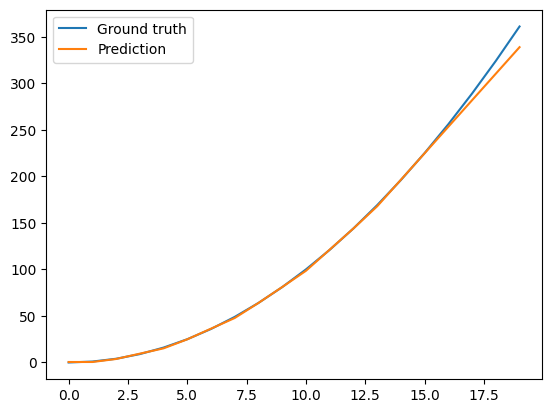

In [ ]:
test(model, [0, 20], 1, loss_fn, device)